In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [8]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [9]:

default_image_size = tuple((256, 256))
# directory_root = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/CrowdAI-Train-Test/color'
# directory_root = 'N:/RiceDetectionGithub/Custom-Train-Test(color)/color'
directory_root = '/home/mazumder_8100/crowdAi/segmented'


width=256
height=256
depth=3


  0%|          | 0/25 [00:00<?, ?it/s]

[INFO] Loading images ...
Processing:  Tomato___Early_blight
Images:  1000


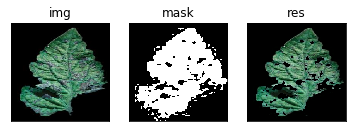

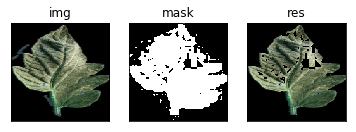

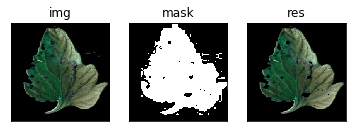

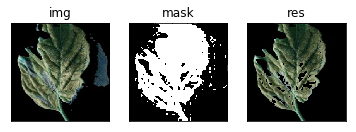

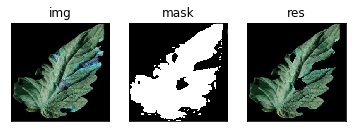

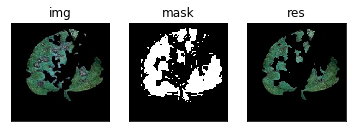

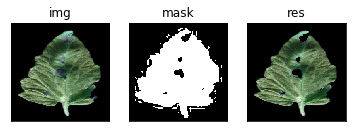

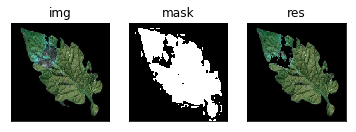

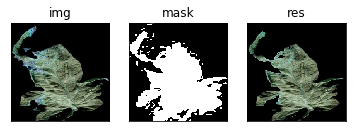

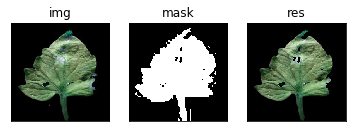

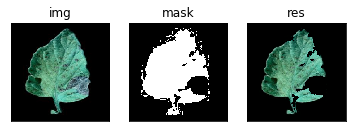

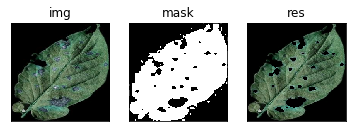

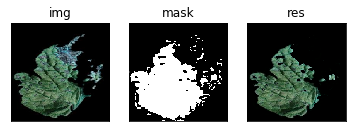

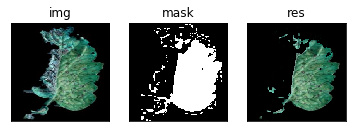

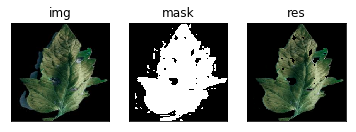

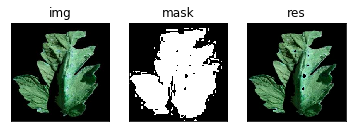

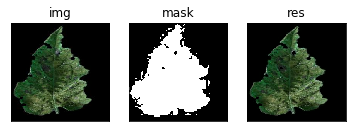

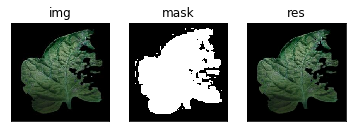

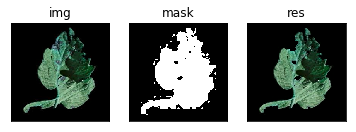

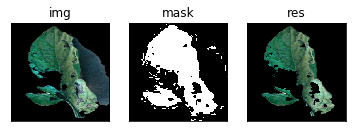

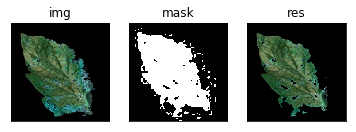

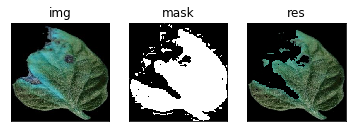

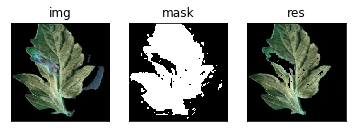

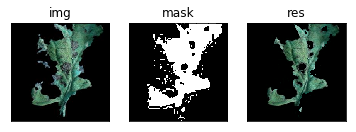

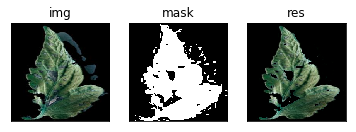

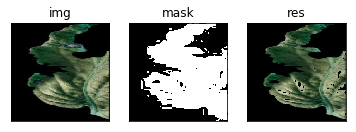

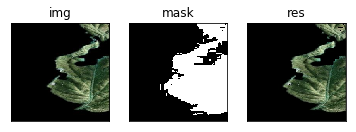

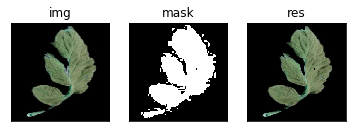

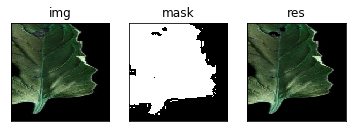

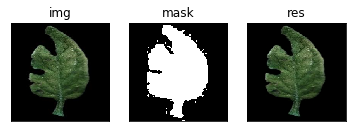

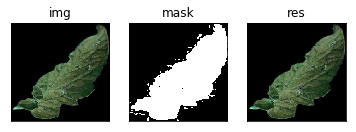

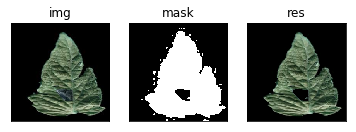

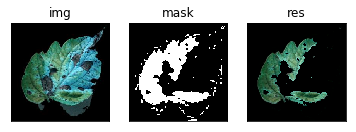

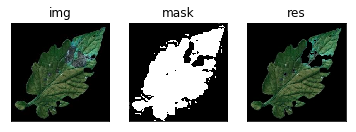

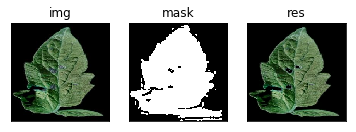

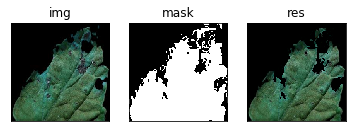

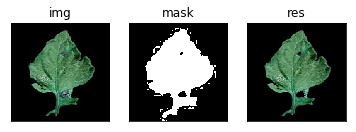

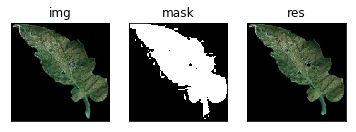

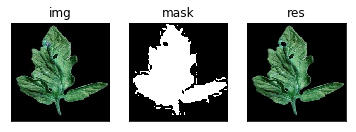

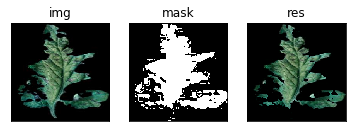

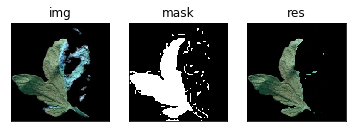

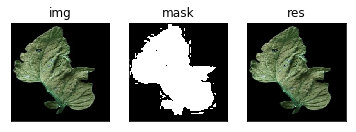

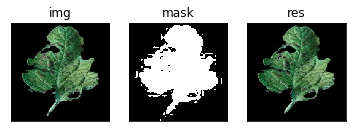

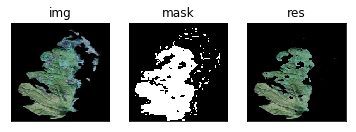

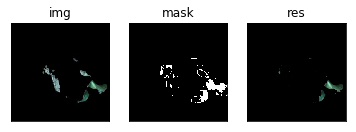

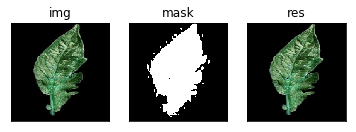

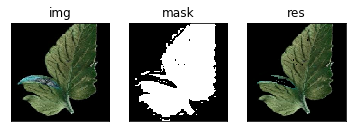

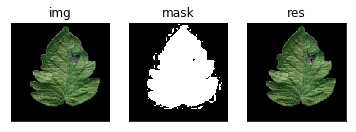

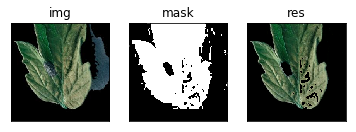

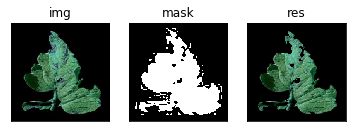

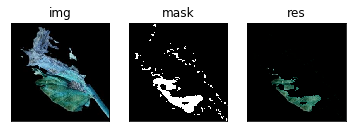

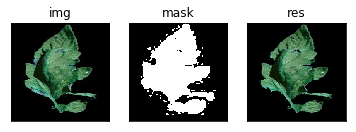

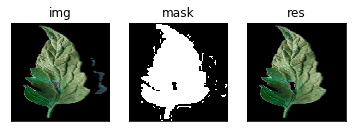

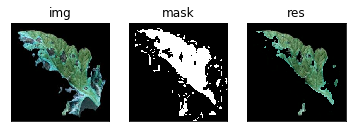

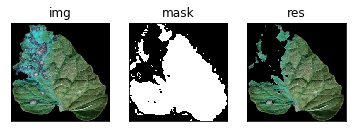

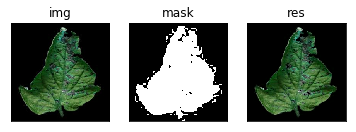

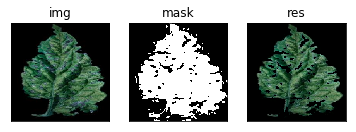

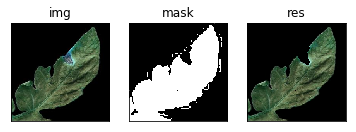

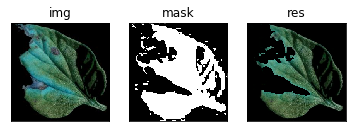

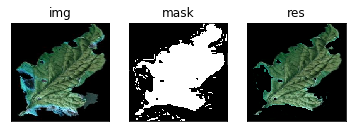

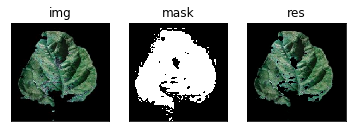

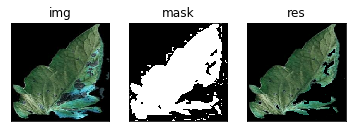

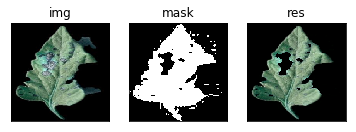

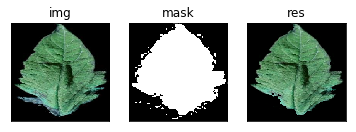

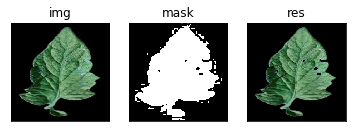

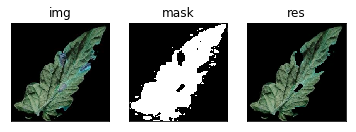

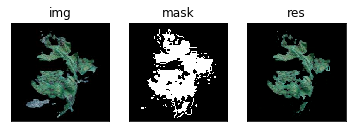

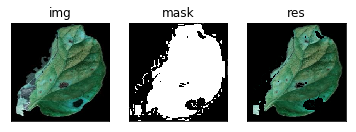

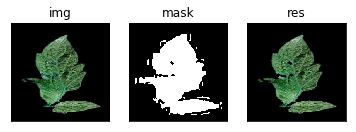

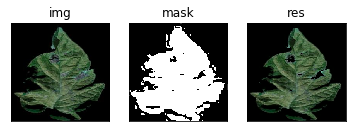

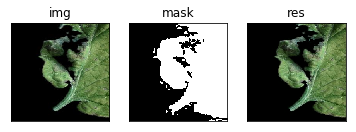

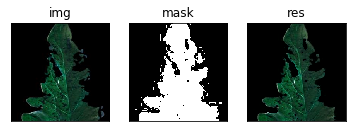

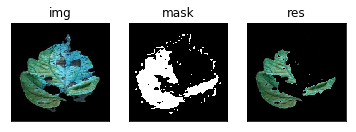

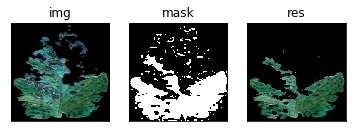

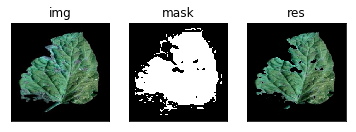

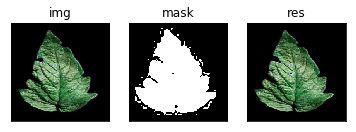

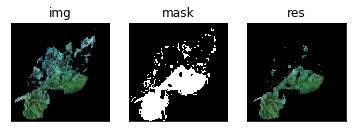

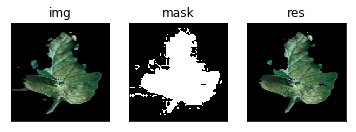

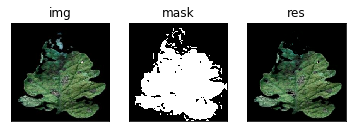

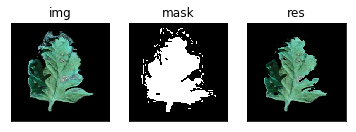

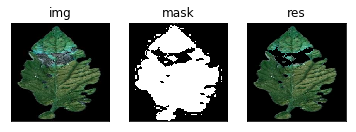

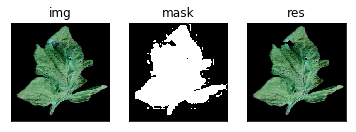

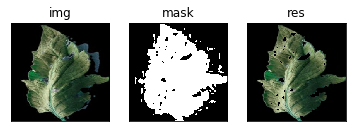

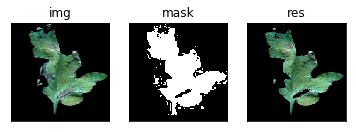

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [10]:
from tqdm import tqdm

image_list, label_list = [], []
# write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'

# write_dir = 'N:/RiceDetectionGithub/Segmented/Processed'

write_dir = '/home/mazumder_8100/crowdAi/processed'

print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for img_folder in tqdm(root_dir):
    print("Processing: ",img_folder)
    plant_disease_image_list = listdir(f"{directory_root}/{img_folder}/")
    print("Images: ",len(plant_disease_image_list))
    for img_name in plant_disease_image_list:
        img_url = directory_root + '/' + img_folder + '/' +img_name
        img = cv2.imread(img_url) #reading image
        # hue sat value -hsv
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        #Green upper and lowerbound
        lower_green = np.array([36,0,0])
        upper_green = np.array([86,255,255])
        
        mask = cv2.inRange(hsv, lower_green, upper_green)
        
        lower_yellow = np.array([15,20,30])
        upper_yellow = np.array([86,100,100])
        
        mask = cv2.inRange(hsv, lower_green, upper_green)
        res = cv2.bitwise_and(img,img, mask= mask)
        plt.subplot(131),plt.imshow(img,cmap = 'gray'),plt.title("img")
        plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(mask,cmap = 'gray'),plt.title('mask')
        plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(res,cmap = 'gray'),plt.title('res')
        plt.xticks([]), plt.yticks([])
        plt.show()
        
        img_write = write_dir + '/' + img_folder + '/' + img_name
        cv2.imwrite(img_write,res)
       
        
    
     

[INFO] Loading images ...
Processing:  Apple___Apple_scab
Images:  600


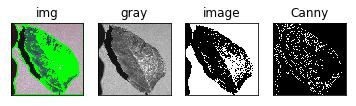

error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\imgproc\src\grabcut.cpp:381: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


In [29]:
#Contour Extraction

image_list, label_list = [], []
# write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'

write_dir = 'N:/RiceDetectionGithub/Segmented/Processed'

print("[INFO] Loading images ...")
root_dir = listdir(directory_root)
for img_folder in root_dir:
    print("Processing: ",img_folder)
    plant_disease_image_list = listdir(f"{directory_root}/{img_folder}/")
    print("Images: ",len(plant_disease_image_list))
    for img_name in plant_disease_image_list:
        img_url = directory_root + '/' + img_folder + '/' +img_name
        im = cv2.imread(img_url) #reading image
        
        #Threshholding contour detect
        imgray  = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray,127,255,0)
        image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        
        
        imgc = cv2.drawContours(im, contours, -1, (0,255,0), 3)

        #Canny 
        edges = cv2.Canny(im,100,200)
           
        plt.subplot(141),plt.imshow(im,cmap = 'gray'),plt.title("img")
        plt.xticks([]), plt.yticks([])
        plt.subplot(142),plt.imshow(imgray,cmap = 'gray'),plt.title('gray')
        plt.xticks([]), plt.yticks([])
        plt.subplot(143),plt.imshow(image,cmap = 'gray'),plt.title('image')
        plt.xticks([]), plt.yticks([])
        plt.subplot(144),plt.imshow(edges,cmap = 'gray'),plt.title('Canny')
        plt.xticks([]), plt.yticks([])
        plt.show()
        
        
        
        img_write = write_dir + '/' + img_folder + '/' + img_name
        cv2.imwrite(img_write,res)
       
        break
        

## Grabcut

In [36]:

im = cv2.imread(img_url) #reading image
im = cv2.blur(im, (5,5))

height, width = im.shape[:2]

mask = np.ones(im.shape[:2], dtype=np.uint8) * 2 #start all possible background
'''
#from docs:
0 GC_BGD defines an obvious background pixels.
1 GC_FGD defines an obvious foreground (object) pixel.
2 GC_PR_BGD defines a possible background pixel.
3 GC_PR_FGD defines a possible foreground pixel.
'''

#2 circles are "drawn" on mask. a smaller centered one I assume all pixels are definite foreground. a bigger circle, probably foreground.
r = 100
cv2.circle(mask, (int(width/2.), int(height/2.)), 2*r, 3, -3) #possible fg
#next 2 are greens...dark and bright to increase the number of fg pixels.
mask[(im[:,:,0] < 45) & (im[:,:,1] > 55) & (im[:,:,2] < 55)] = 1  #dark green
mask[(im[:,:,0] < 190) & (im[:,:,1] > 190) & (im[:,:,2] < 200)] = 1  #bright green
mask[(im[:,:,0] > 200) & (im[:,:,1] > 200) & (im[:,:,2] > 200) & (mask != 1)] = 0 #pretty white

cv2.circle(mask, (int(width/2.), int(height/2.)), r, 1, -3) #fg



bgdmodel = np.zeros((1,65), np.float64)
fgdmodel = np.zeros((1,65), np.float64)
cv2.grabCut(im, mask, None, bgdmodel, fgdmodel, 1, cv2.GC_INIT_WITH_MASK)


plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

#mask image
mask2 = np.where((mask==1) + (mask==3), 255, 0).astype('uint8')
output = cv2.bitwise_and(im, im, mask=mask2)
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.show()



error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\imgproc\src\grabcut.cpp:381: error: (-215:Assertion failed) !bgdSamples.empty() && !fgdSamples.empty() in function 'initGMMs'


In [29]:
import os

In [32]:
write_dir = 'C:/Users/Sakib Mukter/Desktop/RiceProject/Segmented/Processed/'


In [36]:
# for c in root_dir:
#     dira = write_dir + '/' + c
#     os.mkdir(dira)